### <span style="color:rgb(46,139,87)">Optimisation-RO</span>

### <span style="color:rgb(46,139,87)">Certification Chef de projet IA 2023-2024</span>


# <span style="color:rgb(46,139,87)">Notebook de la séance 1 - Optimisation convexe</span>


Pour tout commentaire concernant ce notebook (y compris les typos), merci d'envoyer un mail à **clement.royer@lamsade.dauphine.fr**.

#  <span style="color:rgb(46,139,87)">Introduction</span>

Le but de cette session est d'illustrer des propriétés des problèmes d'optimisation convexe, via l'utilisation d'algorithmes existants pour résoudre des problèmes d'optimisation convexe apparemment complexes.

*Note : Si les différentes parties de ce notebook sont construites de sorte à être indépendantes, les blocs sont fait pour être exécutés de manière séquentielle. On prendra notamment soin d'exécuter le bloc ci-dessous (qui importe des bibliothèques et fonctions utiles) en premier.*

In [1]:
# Imports des bibliothèques et fonctions utiles
###############################################

# Affichage
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Racine carrée
from math import ceil # Partie entière supérieure
from math import log # Logarithme

# NumPy - Structures vectorielles et matricielles
import numpy as np # Bibliothèque complète
from numpy.random import multivariate_normal, randn, uniform, choice, normal, laplace # distributions de probabilité

# SciPy - Calculs mathématiques efficaces
from scipy.linalg import norm # normes classiques
from scipy.linalg import toeplitz # matrices de Toeplitz
from scipy.linalg import svdvals # décomposition en valeurs singulières
from scipy.linalg import qr # factorisation QR
from scipy.linalg import sqrtm # Racine carree de matrice
from scipy.linalg import pinv # Inverse de matrice carree
from scipy.optimize import check_grad # Vérification des dérivées

# Solveurs d'optimisation dans SciPy
# - linprog : Programmation linéaire
# - lsq_linear : Moindres carrés linéaires
from scipy.optimize import fmin_l_bfgs_b, linprog, lsq_linear


# Commande auxiliaire pour l'affichage
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Ce notebook utilise des routines des bibliothèques NumPy and Scipy *(sur Google Colab par défaut, à installer sur votre distribution locale).* Voici un lien vers un bon [tutoriel Numpy (en anglais)](https://sebastianraschka.com/pdf/books/dlb/appendix_f_numpy-intro.pdf).

**Fonctions NumPy utiles (cf documentation pour plus d'informations)**

* *transpose* transposée de matrice (i.e. tableau NumPy bi-dimensionnel). On peut aussi utiliser X.T
* *matmul* produit matrice-matrice (les dimensions doivent être compatibles).
* *dot* produit matrice-vector (si les dimensions sont compatibles), aussi utilisable comme opérateur de produit scalaire entre deux vecteurs de même taille.
* *np.ones((m,n))* matrice de taille m x n avec composantes égales à 1. 
* *np.zeros((m,n))* matrice de taille m x n avec composantes égales à 0.
* *np.identity(n)* matrice identité de taille n x n.
* *np.pi* $\pi$.
* *np.inf* nombre infini en mémoire.
* *np.log* logarithme appliqué à chaque coordonnée des tableaux NumPy.
* *np.exp* exponentielle appliquée à chaque coordonnée des tableaux NumPy.
* *np.sum* somme des composantes d'un tableau NumPy (pour les matrices, somme selon une dimension)
* *np.maximum(u,v)* renvoie un tableau NumPy array dont les composantes sont $max(u_i,v_i)$, si $u_i$ et $v_i$ sont celles de $u$ et $v$.
* *np.concatenate* concatène des tableaux NumPy (vecteurs, matrices) de dimensions compatibles.
* Si t est un tableau NumPy, la fonction *t.shape* renvoie les dimension(s) de ce tableau (utile lorsque l'on cherche à définir un tableau avec les mêmes dimensions.)

# <span style="color:rgb(46,139,87)">Partie 1 - Maxima de vraisemblance et programmation convexe</span>

Dans cette partie, on s'intéresse à une génération de données à partir d'une tendance linéaire. On considère ainsi un jeu de données $\{(\mathbf{a}_i,b_i)\}_{i=1,\dots,n}$, avec $\mathbf{a}_i \in \mathbb{R}^d$ et $b_i \in \mathbb{R}$, et on suppose qu'il existe $\mathbf{x}^* \in \mathbb{R}^d$ tel que 
$$
    \forall i=1,\dots,n, \quad b_i = \mathbf{a}_i^T \mathbf{x}^* + \epsilon_i,
$$
où les $\epsilon_i$ seront des variables aléatoires indépendantes et identiquement distribuées selon l'une des lois suivantes :
 - a) Loi gaussienne de moyenne $0$ et de variance $\lambda>0$;
 - b) Loi de Laplace de moyenne $0$ et de paramètre d'échelle $\lambda>0$;
 - c) Loi uniforme sur l'intervalle $[-\lambda,\lambda]$.
 
Pour chacun de ces choix, on cherchera à calculer le problème de maximum de la vraisemblance via la résolution d'un problème d'optimisation convexe dédié, de la forme 
$$
    \begin{array}{lll}
        \mbox{minimiser}_{\mathbf{z} \in \mathbb{R}^d} &f(\mathbf{z}) \\
        \mbox{s.c.}  &\mathbf{z} \in \mathcal{F}.
    \end{array}
$$
avec $d \ge n$, $f$ une fonction convexe et $\mathcal{F} \subseteq \mathbb{R}^d$ décrit par un ensemble de contraintes d'inégalité convexes et d'égalité linéaires (possiblement vide, auquel cas cet ensemble sera égal à $\mathbb{R}^d$).

## <span style="color:rgb(46,139,87)">1.1 Modèles linéaires et données bruitées</span>

Par définition, les $\epsilon_i$ (et donc les $b_i$) sont des variables aléatoires i.i.d. La densité de probabilité du vecteur $\mathbf{b}$ sera donc donnée par le produit des densités marginales des $b_i$. On a donc les résultats suivants pour chacun des cas possibles:

a) $b_i$ suit une loi normale $\mathcal{N}(\mathbf{a}_i^T \mathbf{x}^*, \lambda)$.
$$
p(\mathbf{b}) = \frac{1}{(2\pi\lambda)^{n/2}} 
\exp\left[ - \frac{\|\mathbf{b}-\mathbf{A x^*}\|^2}{2 \lambda} \right].
$$
b) $b_i$ suit une loi de Laplace $\mathcal{N}(\mathbf{a}_i^T \mathbf{x}^*, \lambda)$.
$$
p(\mathbf{b}) = \frac{1}{(2\lambda)^n} 
\exp\left[ - \frac{\|\mathbf{b}-\mathbf{A} \mathbf{x}^*\|_1}{\lambda} \right].
$$
c) $b_i$ suit une loi uniforme sur $[-\lambda+\mathbf{a}_i^T \mathbf{x}^*,\mathbf{a}_i^T \mathbf{x}^*+\lambda]$.
$$
p(\mathbf{b}) = \frac{1}{(2\lambda)^n} \prod_{i=1}^n \mathbf{1}_{[-\lambda+\mathbf{a}_i^T \mathbf{x}^*,\mathbf{a}_i^T \mathbf{x}^*+\lambda]}(b_i).
$$

La classe de problèmes d'optimisation ci-dessous modélise les problèmes obtenus.

In [2]:
# Classe de modeles lineaires
class ModelLin(object):
    """
    Construction d'une <classe de modeles lineaires avec differents types d'erreurs
    
    Attributs
    ----------
    A : matrice de donnees
    n,d : dimensions de la matrice A
    xstar : "verite terrain" (ground truth) du modele lineaire, vecteur de taille (d,1)
    eps : vecteur des erreurs, de taille (n,1)
    lbda : parametre de la loi de probabilite des erreurs (>0)
    law : loi des entrees du vecteur eps
        'gauss' (defaut): loi normale de moyenne 0 et de variance lambda
        'laplace' : loi de Laplace (0,1/lambda)
        'unif' : loi uniforme sur [-lambda,lambda]
    b : observations bruitees, de taille (n,1)

    
    """   
    
    # Instanciation de la classe
    def __init__(self, A, xstar,lbda,law='gauss'):
        self.A = A
        self.n, self.d = A.shape
        self.xstar = xstar
        self.lbda=lbda
        self.law=law

        # Pour chacune des lois considerees, on calcule les valeurs des
        # attributs b et eps
        if law=='gauss':
            self.eps = normal(0,lbda,size=n)
        elif law=='laplace':
            self.eps = laplace(0,lbda,size=n)
        elif law=='unif':
            self.eps = uniform(-lbda,lbda,size=n)
        
        self.b = self.A.dot(self.xstar)+self.eps


Valider l'implémentation au moyen du code ci-dessus, qui affiche le résultat lorsque $d=1$, et observer la distribution des points ainsi générés.

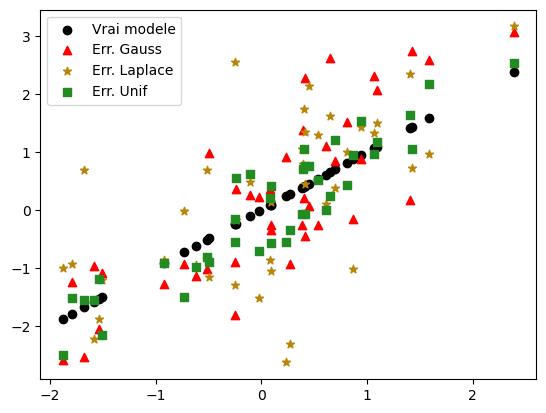

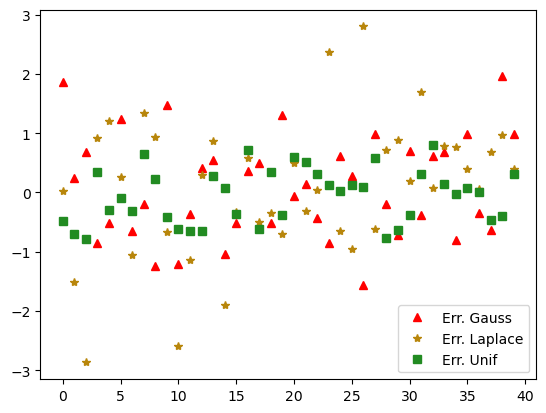

In [3]:
# On instancie plusieurs fois la classe pour afficher les resultats

d=1
n=40
idx = np.arange(d)
xstar = (-1)**idx * np.exp(-idx / 10.)
corr = 0.5
A = multivariate_normal(np.zeros(d), toeplitz(corr ** np.arange(0, d)), size=n)
b = A.dot(xstar) #Tendance lineaire veritable
lbda = 0.8

mlg = ModelLin(A,xstar,lbda,'gauss')
mll = ModelLin(A,xstar,lbda,'laplace')
mlu = ModelLin(A,xstar,lbda,'unif')

if d==1:
    # Trace des points initiaux
    plt.figure()
    plt.scatter(A[:,0],b,color='k',marker='o',label='Vrai modele')
    plt.scatter(A[:,0],mlg.b,color='red',marker='^',label='Err. Gauss')
    plt.scatter(A[:,0],mll.b,color='darkgoldenrod',marker='*',label='Err. Laplace')
    plt.scatter(A[:,0],mlu.b,color='forestgreen',marker='s',label='Err. Unif')
    plt.legend()
    plt.show()

    #Trace des erreurs
    plt.figure()
    plt.plot(mlg.eps,'^',color='red',label='Err. Gauss')
    plt.plot(mll.eps,'*',color='darkgoldenrod',label='Err. Laplace')
    plt.plot(mlu.eps,'s',color='forestgreen',label='Err. Unif')
    plt.legend()
    plt.show()

On va maintenant chercher à calculer l'estimateur du maximum de vraisemblance pour les différentes lois possibles des erreurs. Pour ce faire, on reformule les problèmes de la façon la plus simple possible en des problèmes de minimisation convexe, puis on fait appel à des solveurs dédiés de la bibliothèque SciPy.

## <span style="color:rgb(46,139,87)">1.2 - Reformulations convexes</span>

Etant donné notre vecteur d'observations $\mathbf{y} \in \mathbb{R}^n$, on considère une famille de lois de probabilité $p_{\mathbf{x}}(\cdot)$ paramétrée par un vecteur $\mathbf{x} \in \mathbb{R}^d$. La vraisemblance est alors définie par
$$
    \mathbf{x} \; \mapsto \; p_{\mathbf{x}}(\mathbf{y}).
$$
et la *log-vraisemblance* correspond au logarithme de cette fonction. L'estimateur du maximum de vraisemblance est alors obtenu en résolvant le problème
$$
    \mbox{maximiser}_{\mathbf{x} \in \mathbb{R}^d} \ell(\mathbf{x}):= \ln\left[p_{\mathbf{x}}(\mathbf{y})\right].
$$
Dans tous les cas à venir, on obtient une formulation convexe en formant tout d'abord la log-vraisemblance, puis en prenant l'opposée pour obtenir un problème de minimisation. 

a) $\epsilon_i \sim \mathcal{N}(0,\lambda)$: ce cas correspond à un problème aux moindres carrés linéaires. À une constante près, le problème de maximisation de la log-vraisemblance correspond en effet à 
$$
    \mbox{maximiser}_{\mathbf{x} \in \mathbb{R}^d} -\frac{1}{2}\left\| \mathbf{A x}-\mathbf{b}\right\|^2,
$$
qui possède exactement le même ensemble de solutions que
$$
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} \frac{1}{2}\left\|\mathbf{A x}-\mathbf{b}\right\|^2.
$$
Ce problème est un problème aux moindres carrés linéaires, qui est toujours convexe (sa matrice Hessienne étant $\mathbf{A}^T \mathbf{A} \succeq \mathbf{O}$).


b) $\epsilon_i \sim \mbox{Laplace}(0,\lambda)$: En utilisant la formule de la vraisemblance et sans considérer les termes constants, le problème de calcul du maximum de vraisemblance est équivalent à
$$
    \mbox{maximiser}_{\mathbf{x} \in \mathbb{R}^d} -\frac{1}{\lambda} \left\|\mathbf{A} \mathbf{x}-\mathbf{b}\right\|_1,
$$
au sens où les problèmes possèdent le même ensemble de solutions.
La quantité $\lambda$ étant strictement positive, cet ensemble de solutions est également celui du problème
$$
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} \left\|\mathbf{A} \mathbf{x}-\mathbf{b}\right\|_1 = \sum_{i=1}^m \left| \mathbf{a}_i^T \mathbf{x} - b_i \right|,
$$
qui est un problème convexe mais dont l'objectif n'est pas partout dérivable. En rajoutant des variables supplémentaires, il est cependant possible de supprimer les valeurs absolues et d'obtenir ainsi un problème convexe avec contraintes linéaires :
$$
    \begin{array}{lll}
    \mbox{minimiser}_{\substack{\mathbf{x} \in \mathbb{R}^d \\ \mathbf{t}^+ \in \mathbb{R}^n
    \\ \mathbf{t}^- \in \mathbb{R}^n}} 
    &\sum_{i=1}^n \left( [\mathbf{t}^+]_i + [\mathbf{t}^-]_i \right) & \\
    \mbox{s. c.} &[\mathbf{t}^+]_i \ge 0 &i=1,\dots,n \\
    &[\mathbf{t}^-]_i \ge 0 &i=1,\dots,n \\
    &[\mathbf{t}^+]_i -[\mathbf{t}^-]_i - (\mathbf{a_i}^T \mathbf{x} -b_i) = 0 &i=1,\dots,n.
    \end{array}
$$
Ce problème est un programme linéaire, dont l'objectif et les $3n$ contraintes sont linéaires en les $d+2n$ variables $(\mathbf{x},\mathbf{t}^+,\mathbf{t}^-)$.

c) $\epsilon_i \sim U([-\lambda,\lambda])$: À une constante près, le problème de calcul de l'estimateur du maximum de vraisemblance s'écrit:
$$
    \mbox{maximiser}_{\mathbf{x} \in \mathbb{R}^d} 
    \sum_{i=1}^n \ln\left[\mathbf{1}_{[-\lambda+\mathbf{a}_i^T \mathbf{x},\lambda+\mathbf{a}_i^T \mathbf{x}]}(b_i)\right],
$$
qui est équivalent au problème de minimisation
$$
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} 
    -\sum_{i=1}^n \ln\left[\mathbf{1}_{[-\lambda+\mathbf{a}_i^T \mathbf{x},\lambda+\mathbf{a}_i^T \mathbf{x}]}(b_i)\right],
$$
La fonction objectif prend la valeur $-\inf$ en tout point $\mathbf{w}$ pour lequel
$y_i \notin [-\lambda+\mathbf{a}_i^T \mathbf{x},\lambda+\mathbf{a}_i^T \mathbf{x}]$ pour 
au moins un indice $i \in \{1,\dots,n\}$, et la valeur 0 sinon. On peut donc écrire ce problème comme un problème de réalisabilité (c'est-à-dire à fonction objectif constante) de la manière suivante:
$$
    \begin{array}{lll}
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} &0 &\\
    \mbox{s.c.} &-\lambda + \mathbf{a}_i^T \mathbf{x} - b_i \le 0 &i=1,\dots,n\\
    &-\lambda - \mathbf{a}_i^T \mathbf{x} + b_i \le 0 &i=1,\dots,n.
    \end{array}
$$
Ce problème est convexe; il appartient à la catégorie des problèmes de programmation linéaires.

Les deux classes ci-dessous permettent d'encoder les problèmes développés plus haut, et de les résoudre directement via des solveurs de la bibliothèque SciPy. La première de ces classes permet de représenter les problèmes aux moindres carrés linéaires de la forme
$$
    \begin{array}{lll}
        \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} &\frac{1}{2}\left\|\mathbf{A} \mathbf{x}-\mathbf{b}\right\|^2 \\
        \mbox{s.c.} &\mathbf{l}_b \le \mathbf{x} \le \mathbf{u}_b.
    \end{array}
$$

In [4]:
# Classe pour les problemes aux moindres carres lineaires
class LinLsq(object):
    """
    Classe pour les problemes de moindres carres lineaires de la forme
        minimiser (1/2)*||A x - b||^2
        s.c. lb <= w <= ub
    
    Attributs
    ----------
    
    A : Matrice du modele lineaire
    b : Second membre du modele lineaire
    bds : suite d'elements (l,u) formant des bornes sur chaque variable
        Si bds =(c,d) avec c et d deux constantes, la meme borne est appliquee a toutes
        les variables
        Utiliser None pour des variables non bornees
        
    Methodes
    --------
    
    resol : Resoudre le probleme via un appel a la methode lsq_linear de SciPy

    
    """   

    
    
    # Instanciation de la classe
    def __init__(self, A, b,bds=(None,None)):
        self.A = A
        self.b = b
        self.bds = bds
        
    # Resolution du probleme aux moindres carres lineaires sous-jacent via le solveur 
    # lsq_linear (note: ce solveur permet de preciser des bornes sur la variable)
    def resol(self):
        return lsq_linear(self.A, self.b, bounds=self.bds)

La classe ci-dessous encode les programmes linéaires de la forme
$$
    \begin{array}{lll}
        \min_{\mathbf{x} \in \mathbb{R}^d} &\mathbf{c}^T \mathbf{x} \\
        \mbox{s.c.} &\mathbf{A}_i \mathbf{x} - \mathbf{b}_i \le \mathbf{0}\\
        &\mathbf{A}_e \mathbf{x} - \mathbf{b}_e \le \mathbf{0} \\
        &\mathbf{l}_b \le \mathbf{x} \le \mathbf{u}_b.
    \end{array}
$$
*Dans les logiciels de programmation linéaire, les contraintes de bornes sur les variables font généralement l'objet d'un traitement spécifique.*

In [5]:
# Classe pour les programmes lineaires
class LinOpt(object):
    """
    Classe pour les problemes de programmation lineaire de la forme
        minimiser c^T x
        s.c. A_e x - b_e = 0
             A_i x - b_i <= 0
             lb <= x <= ub
    
    Attributs
    ----------
    
    c : vecteur definissant la fonction de cout
    A_e : Matrice correspondant aux contraintes d'egalite lineaires
    b_e : Second membre des contraintes d'egalite lineaires
    A_i : Matrice correspondant aux contraintes d'inegalite lineaires
    b_i : Second membre des contraintes d'inegalite lineaires
    bds : suite d'elements (lb,ub) formant des bornes sur chaque variable
        Si bds =(c,d) avec c et d deux constantes, la meme borne est appliquee a toutes
        les variables
        Utiliser None pour des variables non bornees
        
    Methodes
    --------
    
    resol : Resoudre le probleme via un appel a la methode linprog de SciPy

    
    """   

    # Instanciation de la classe
    def __init__(self, c, A_e=None, b_e=None, A_i=None, b_i=None, bds=(None,None)):
        self.c=c
        self.A_e=A_e
        self.b_e=b_e
        self.A_i=A_i
        self.b_i=b_i
        self.bds=bds
        
    # Resolution du probleme par une methode de points interieurs
    def resol(self):
        return linprog(c=self.c, A_ub=self.A_i, b_ub=self.b_i, A_eq=self.A_e, b_eq=self.b_e, bounds=self.bds, method='interior-point')

Pour chacun des problèmes de minimisation convexe, on crée une instance appropriée et calculer la solution du problème.

Ecart avec verite terrain :  0.21525431319491917
Fonction de cout :  14.204432868942096
Norme du gradient :  8.520888302887448e-15


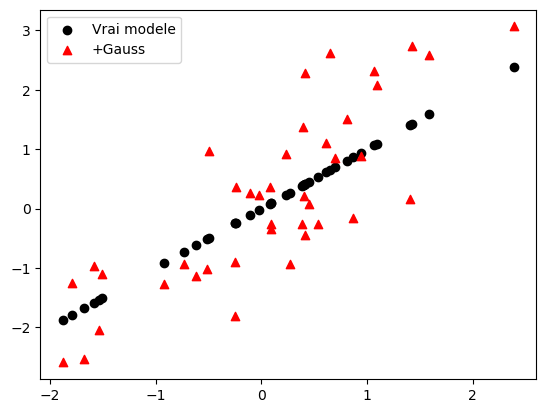

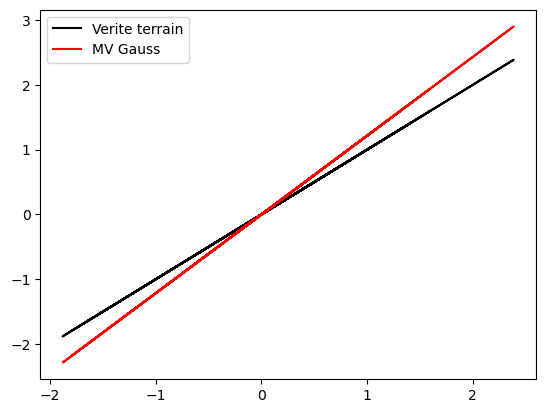

In [6]:
# Instanciation pour le probleme du maximum de vraisemblance avec erreurs gaussiennes.

# On instancie la classe LinLsq pour representer le probleme considere

lsqgauss = LinLsq(mlg.A,mlg.b) # Instance obtenue


resgauss = lsqgauss.resol()

# Ecart absolu avec la verite terrain
print('Ecart avec verite terrain : ',norm(xstar-resgauss.x))

# Valeur de la fonction de cout
print('Fonction de cout : ', resgauss.cost)

# Norme du gradient
print('Norme du gradient : ', resgauss.optimality)


if d==1:
    # Affichage des points initiaux
    plt.figure()
    plt.scatter(A[:,0],b,color='k',marker='o',label='Vrai modele')
    plt.scatter(A[:,0],mlg.b,color='red',marker='^',label='+Gauss')
    plt.legend()
    plt.show()
    
    # Trace des donnees et des predictions
    plt.figure()
    plt.plot(A[:,0],A.dot(xstar),color='k',label='Verite terrain')
    plt.plot(A[:,0],A.dot(resgauss.x),color='red',label='MV Gauss')
    plt.legend()
    plt.show()


Ecart verite terrain :  0.05504475900146222
Fonction cout :  35.81107938654184


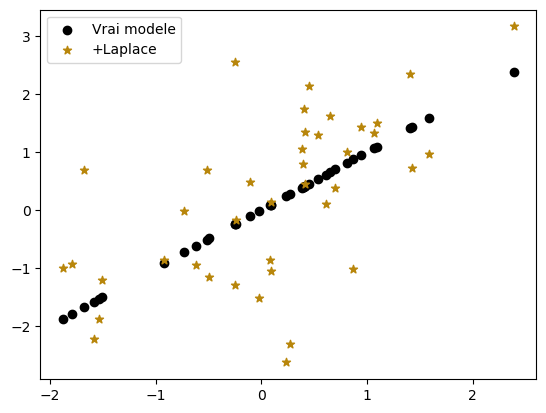

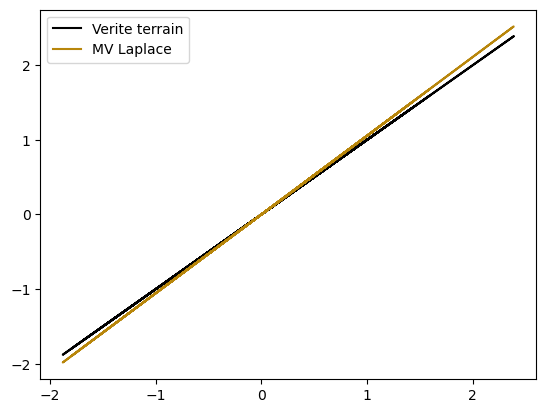

In [7]:
# Calcul du maximum de vraisemblance avec erreurs de Laplace

#  On instancie la classe LinOpt pour representer le probleme avec erreurs de Laplace
#  tel qu'etabli en partie theorique

dlap = mll.d+2*(mll.n)

# Vecteur clap - clap[i]=0 pour x_i, clap[i]=1 pour t^+_i et  t^-_i
clap= np.ones(dlap)
clap[0:(mll.d)]=0

# Matrice de contraintes d'egalite
Im = np.identity(mll.n)
Alap = np.concatenate((mll.A,-Im,Im),axis=1)
blap = mll.b

# Bornes 
laux = []
for i in range(d):
    laux.append((None,None))
for i in range(d,dlap):
    laux.append((0,None))
bdslap = tuple(laux)

# Instanciation
lplaplace = LinOpt(c=clap,A_e=Alap,b_e=blap,bds=bdslap) # Instance obtenue


reslaplace=lplaplace.resol()

# Ecart absolu avec la verite terrain
print('Ecart verite terrain : ',norm(xstar-reslaplace.x[0:mll.d]))

# Valeur de la fonction de coit
print('Fonction cout : ',reslaplace.fun)



if d==1:
    # Affichage des points initiaux
    plt.figure()
    plt.scatter(A[:,0],b,color='k',marker='o',label='Vrai modele')
    plt.scatter(A[:,0],mll.b,color='darkgoldenrod',marker='*',label='+Laplace')
    plt.legend()
    plt.show()
    
    # Affichage de la verite terrain et de son estimateur
    plt.figure()
    plt.plot(A[:,0],A.dot(xstar),color='k',label='Verite terrain')
    plt.plot(A[:,0],A.dot(reslaplace.x[0:mll.d]),color='darkgoldenrod',label='MV Laplace')
    plt.legend()
    plt.show()

0.022005957067567472
8.220506758492224


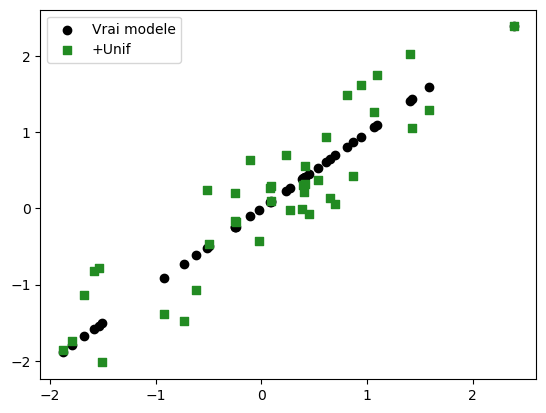

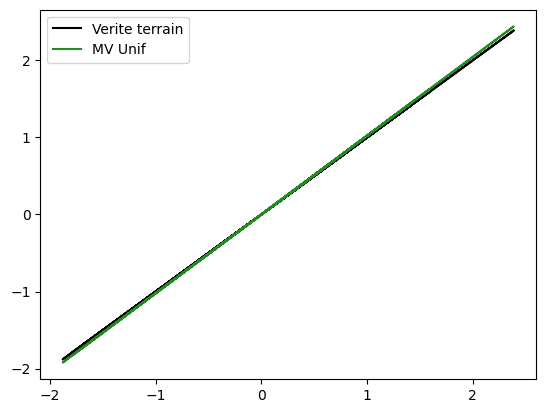

In [8]:
# Calcul du maximum de vraisemblance avec erreurs uniformes

mlu = ModelLin(A,xstar,lbda,'unif')

#  On instancie la classe LinOpt pour representer le probleme avec erreurs uniformes
#  tel qu'etabli en partie theorique


# Vecteur cunif (objectif nul)
cunif= np.zeros(mlu.d)

# Matrice de contraintes d'inegalite
Aunif = np.concatenate((mlu.A,-mlu.A),axis=0)
bunif = mlu.lbda+ np.concatenate((mlu.b,-mlu.b),axis=0)

# Instanciation
lpunif = LinOpt(c=cunif,A_i=Aunif,b_i=bunif) # Instance obtenue


resunif=lpunif.resol()

# Ecart absolu avec la vérité terrain
print(norm(xstar-resunif.x))

# Valeur de la satisfaction des contraintes
print(norm(resunif.slack))


if d==1:
    # Affichage des points initiaux
    plt.figure()
    plt.scatter(A[:,0],b,color='k',marker='o',label='Vrai modele')
    plt.scatter(A[:,0],mlu.b,color='forestgreen',marker='s',label='+Unif')
    plt.legend()
    plt.show()
    
    # Affichage de la verite terrain et de son estimateur
    plt.figure()
    plt.plot(A[:,0],A.dot(xstar),color='k',label='Verite terrain')
    plt.plot(A[:,0],A.dot(resunif.x),color='forestgreen',label='MV Unif')
    plt.legend()
    plt.show()

*Commentaire : La variante avec erreurs uniformes semble la plus simple à minimiser. Cependant, lorsque la valeur de $\lambda$ est importante, le problème d'optimisation possède un grand nombre de solutions, parmi lesquelles il est impossible de faire un choix au sens de l'optimisation. À l'inverse, lorsque $\lambda \rightarrow 0$ et que la distribution tend vers une valeur ponctuelle, le problème se ramène à la résolution du système $\mathbf{X}\mathbf{w} = \mathbf{y}$.*

## <span style="color:rgb(46,139,87)">1.3 - Régularisation et a priori</span>

On considère maintenant au cas d'un modèle linéaire avec erreurs gaussiennes selon une loi normale $\mathcal{N}(0,1)$, et on considère donc une famille de densités gaussiennes $\mathcal{N}\left(\mathbf{A}\mathbf{x},\mathbf{I}\right)$. 

On suppose de surcroît un a priori sur $\mathbf{x}^*$; plus spécifiquement, on supposera 
que les entrées de $\mathbf{x}$ sont i.i.d. selon l'une des lois suivantes :

a) loi normale $\mathcal{N}\left(0,\frac{1}{\mu}\right)$ avec $\mu>0$;

b) loi uniforme $U_{[\mathbf{0},\mathbf{1}]}$;

c) loi $\mathrm{Beta}(2,1)$.

*On rappelle ici l'expression de la densité de probabilité d'une loi $\mathrm{Beta}(2,1)$, dont le support est $[0,1]$ :*
$$
    \forall z \in [0,1], \quad p(z) = 2 z.
$$

Étant données une famille de distributions $\{p_{\mathbf{y}|\mathbf{x}}(\cdot)\}$ sur $\mathbb{R}^n$ paramétrée par $\mathbf{x} \in \mathbb{R}^d$ et une famille de distributions a priori $\{p_{\mathbf{x}}(\cdot)\}$ sur $\mathbb{R}^d$, le problème de calcul du maximum a posteriori est donné par
$$
    \mbox{maximiser}_{\mathbf{x} \in \mathbb{R}^d} \left\{ \ln\left[p_{\mathbf{y}|\mathbf{x}}(\mathbf{y})\right] + \ln\left[ p_{\mathbf{x}}(\mathbf{x})\right] \right\}.
$$

On utilise la formulation classique du problème de maximum a posteriori en omettant les termes constants, qui ne jouent aucun rôle dans l'optimisation.  On obtient ainsi les trois résultats suivants :

a) Le premier cas donne
$$
    \mbox{maximiser}_{\mathbf{x} \in \mathbb{R}^d} -\frac{1}{2}\left\|\mathbf{A}\mathbf{x}-\mathbf{b}\right\|^2 - \frac{\mu}{2}\|\mathbf{x}\|^2,
$$
qui est équivalent au problème fortement convexe
$$
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} \frac{1}{2}\left\|\mathbf{A}\mathbf{x}-\mathbf{b}\right\|^2 + \frac{\mu}{2}\|\mathbf{x}\|^2.
$$
On notera (utile pour la partie pratique) que ce problème se met sous la forme d'un problème aux moindres carrés comme suit :
$$
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} \frac{1}{2}\left\| \mathbf{H}\mathbf{x}-\mathbf{g}\right\|^2, \quad \mathbf{H} := \left( \mathbf{A}^T \mathbf{A} + \mu \mathbf{I} \right)^{1/2}, 
    \quad \mathbf{g} := \mathbf{H}^{-1} \mathbf{A}^T \mathbf{b}.
$$

b) Les densités a priori sont de la forme
$$
    p_{\mathbf{x}}(\mathbf{x}) =  \prod_{i=1}^d \mathbf{1}_{[0,1]}(x_i).
$$
Le problème d'estimation du maximum a posteriori s'écrit alors
$$
    \mbox{maximiser}_{\mathbf{x} \in \mathbb{R}^d} -\frac{1}{2}\left\|\mathbf{A}\mathbf{x}-\mathbf{b}\right\|^2 + \sum_{i=1}^d \ln\left[\mathbf{1}_{[0,1]}(x_i)\right],
$$
on peut reformuler le probl\`eme comme un problème de minimisation avec contraintes de bornes:
$$
    \begin{array}{lll}
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} 
    &\frac{1}{2}\left\|\mathbf{A}\mathbf{x}-\mathbf{b}\right\|^2 & \\
    \mbox{s.c.} &0 \le x_i \le 1 &i=1,\dots,d.
    \end{array}
$$

c) En utilisant la formule de la densité bêta et le fait que l'a priori sur $\mathbf{x}$ suppose que les entrées sont i.i.d., on obtient
$$
    p_{\mathbf{x}}(\mathbf{x}) = 2^d \prod_{i=1}^d x_i \mathbf{1}_{[0,1]}(x_i).
$$
En introduisant cela dans la formule du problème d'estimation du maximum a posteriori et en enlevant les termes constants de l'objectif, on obtient le problème
$$
    \begin{array}{lll}
    \mbox{maximiser}_{\mathbf{x} \in \mathbb{R}^d} &-\frac{1}{2}\left\|\mathbf{A}\mathbf{x}-\mathbf{b}\right\|^2 + \sum_{i=1}^d \ln(x_i) & \\
    \mbox{s.c.} &0 \le x_i \le 1 &i=1,\dots,n.
    \end{array}
$$
qui est équivalent au problème convexe
$$
    \begin{array}{lll}
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} &\frac{1}{2}\left\|\mathbf{A}\mathbf{x}-\mathbf{b}\right\|^2 - \sum_{i=1}^d \ln(x_i)& \\
    \mbox{s.c.} &0 \le x_i \le 1 &i=1,\dots,n.
    \end{array}
$$
Ce problème est convexe,

Le code ci-dessous, basé sur la classe LinLsq, calcule l'estimateur du maximum a posteriori pour les choix a) (avec $\mu=10$) et b), et compare les valeurs obtenues à celle sans a priori.

Ecart MV :  0.10953486333093798
Ecart MAP Gauss :  0.29212787191317724
Ecart MAP Unif :  0.10953486333093798
Fonction de cout MV :  30.229498744402523
Fonction de cout MAP Gauss :  3.944304526105059e-31
Fonction de cout MAP Unif :  30.229498744402523
Norme gradient MV : 1.1514184713485644e-14
Norme gradient MAP Gauss : 6.20249759981874e-15
Norme gradient MAP Unif : 1.1514184713485644e-14


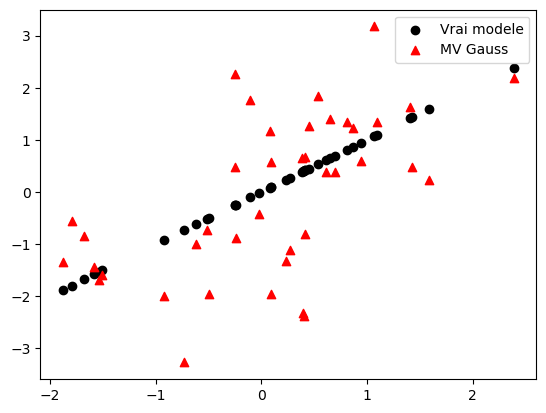

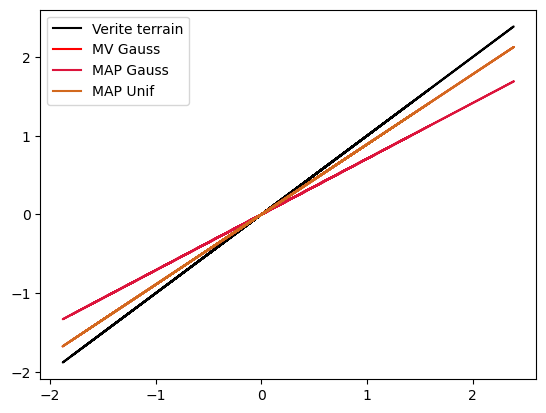

In [9]:
# Instanciation pour le problème du maximum de vraisemblance 
# avec erreurs gaussiennes standards.

mlgs = ModelLin(A,xstar,1,'gauss')
lsqmvg = LinLsq(mlgs.A,mlgs.b) # Probleme sans a priori


# On instancie la classe LinLsq pour encoder les problemes de calcul du maximum 
# a posteriori pour chacun des deux a priori

mu = 10
H = np.matmul(mlgs.A.T,mlgs.A)+mu*np.identity(d)
H = sqrtm(H)
Hi = pinv(H)@(mlgs.A.T)
lsqmapgg = LinLsq(H,Hi.dot(mlgs.b))#Instance avec a priori gaussien (mu=10)

lsqmapgu = LinLsq(mlgs.A,mlgs.b,bds=(0,1))



resmvg = lsqmvg.resol()
resmapgg = lsqmapgg.resol()
resmapgu = lsqmapgu.resol()

# Ecart absolu avec la vérité terrain
print('Ecart MV : ', norm(xstar-resmvg.x))
print('Ecart MAP Gauss : ', norm(xstar-resmapgg.x))
print('Ecart MAP Unif : ', norm(xstar-resmapgu.x))

# Valeur de la fonction de coût
print('Fonction de cout MV : ',resmvg.cost)
print('Fonction de cout MAP Gauss : ',resmapgg.cost)
print('Fonction de cout MAP Unif : ',resmapgu.cost)

# Norme du gradient
print('Norme gradient MV :', resmvg.optimality)
print('Norme gradient MAP Gauss :', resmapgg.optimality)
print('Norme gradient MAP Unif :', resmapgu.optimality)


if d==1:
    # Affichage des points initiaux
    plt.figure()
    plt.scatter(A[:,0],b,color='k',marker='o',label='Vrai modele')
    plt.scatter(A[:,0],mlgs.b,color='red',marker='^',label='MV Gauss')
    plt.legend()
    plt.show()
    
    # Affichage de la verite terrain et des predictions
    plt.figure()
    plt.plot(A[:,0],A.dot(xstar),color='k',label='Verite terrain')
    plt.plot(A[:,0],A.dot(resmvg.x),color='red',label='MV Gauss')
    plt.plot(A[:,0],A.dot(resmapgg.x),color='crimson',label='MAP Gauss')
    plt.plot(A[:,0],A.dot(resmapgu.x),color='chocolate',label='MAP Unif')
    plt.legend()
    plt.show()


# <span style="color:rgb(46,139,87)">Partie 2 - Régression non linéaire et logistique</span>

Dans la partie précédente, nous avons vu un choix d'a priori qui conduisait à un problème sans contraintes avec un objectif non linéaire (et dont le domaine n'était pas nécessairement $\mathbb{R}^d$).

En *régression logistique*, on cherche à réaliser une classification binaire, c'est-à-dire que l'on dispose d'un jeu de données $\{(\mathbf{a}_i,b_i)\}_{i=1}^n$ où $\mathbb{a}_i \in \mathbb{R}^d$ et $b_i \in \{0,1\}$.

Il s'agit alors de postuler que les observations $b_i$ sont indépendantes, et que $b_i$ suit une loi de Bernoulli définie par
$$
    \mathbb{P}(b_i=0) = 
    \frac{\exp[-\mathbf{a}_i^T \mathbf{x}^*]}{1+\exp[-\mathbf{a}_i^T \mathbf{x}^*]}.
$$
On parlera de $\mathbf{x}^*$ comme du paramètre de la loi, et il s'agit de celui que l'on souhaitera estimer. On consid\`erera la famille de densit\'es de probabilit\'e de la forme ci-dessus, paramétrée par un vecteur $\mathbf{x} \in \mathbb{R}^d$. On supposera aussi un a priori gaussien sur les entrées de $\mathbf{x}$ suivant une loi $\mathcal{N}\left(\mathbf{0},\tfrac{1}{\mu}\mathbf{I}\right)$.

La fonction de vraisemblance est définie pour tout $\mathbf{w} \in \mathbb{R}^d$ par
$$
    p_{\mathbf{x}}(\mathbf{b}):= \prod_{i=1}^n \left[\frac{\exp[-\mathbf{a}_i^T \mathbf{b}^*]}{1+\exp[-\mathbf{a}_i^T \mathbf{x}^*]}\right]^{1-b_i} 
    \left[\frac{1}{1+\exp[-\mathbf{x}_i^T \mathbf{w}^*]}\right]^{y_i} 
    = \prod_{i: b_i=0} \frac{\exp[-\mathbf{a}_i^T \mathbf{x}^*]}{1+\exp[-\mathbf{a}_i^T \mathbf{x}^*]}\, \prod_{i: b_i=1} \frac{1}{1+\exp[-\mathbf{a}_i^T \mathbf{x}^*]}
$$
En passant au logarithme, on obtient le problème de maximisation suivant
$$
    \mbox{maximiser}_{\mathbf{x} \in \mathbf{R}^d} \left\{ \sum_{i: b_i=0} \ln\left( \frac{\exp(-\mathbf{a}_i^T \mathbf{x})}{1+\exp(-\mathbf{a}_i^T \mathbf{x})}\right) + \sum_{i: b_i=1} \ln\left( \frac{1}{1+\exp(-\mathbf{a}_i^T \mathbf{x})} \right) \right\} = 
    -\sum_{i: b_i=0}  \mathbf{a}_i^T \mathbf{x} -\sum_{i=1}^n \ln(1+\exp(-\mathbf{a}_i^T \mathbf{x})).
$$
La fonction $\mathbf{x} \mapsto -\mathbf{a}_i^T \mathbf{x}$ est linéaire donc concave. Par ailleurs, la fonction $t \mapsto \ln(1+\exp(-t))$ est convexe, donc par composition $\mathbf{x} \mapsto -\ln(1+\exp(-\mathbf{a}_i^T \mathbf{x}))$ est concave. Ce problème de maximisation de la log-vraisemblance est donc bien concave.

- La famille des densités a priori correspond à une loi normale : on aura donc
$$
    p_{\mathbf{x}}(\mathbf{x}) = \left[ \frac{1}{\sqrt{2\pi\mu}} \right]^d
    \exp\left[- \frac{\mu}{2} \|\mathbf{x}\|^2 \right].
$$
Par conséquent, le problème d'estimation du maximum de vraisemblance s'écrira 
$$
    \mbox{maximiser}_{\mathbf{x} \in \mathbb{R}^d} -\sum_{i: b_i=0}  \mathbf{a}_i^T \mathbf{x} -\sum_{i=1}^n \ln(1+\exp(-\mathbf{a}_i^T \mathbf{x})) - \frac{d}{2}\ln(2\pi\mu) - \frac{\mu}{2} \|\mathbf{x}\|^2
$$
qui est équivalent au problème convexe
$$
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}):= \sum_{i: b_i=0}  \mathbf{a}_i^T \mathbf{x} +\sum_{i=1}^n \ln(1+\exp(-\mathbf{a}_i^T \mathbf{x})) + \frac{\mu}{2}\|\mathbf{x}\|^2.
$$


- La dérivée de la fonction $t \mapsto \ln(1+\exp(-t))$ est $t \mapsto \frac{-\exp(-t)}{1+\exp(-t)} = -\frac{1}{1+\exp(t)}$. Par composition avec la fonction linéaire $\mathbf{x} \mapsto \mathbf{a}_i^T \mathbf{x}$, on voit que le gradient de la fonction 
$\mathbf{x} \mapsto \ln\left(1+ \exp(-\mathbf{a}_i^T \mathbf{x})\right)$ est égal à
$$
- \frac{1}{1 + \exp(\mathbf{a}_i^T \mathbf{x})} \mathbf{a}_i.
$$
Par conséquent, on obtient
$$
\nabla f(\mathbf{x}) = \sum_{i:b_i=0} \mathbf{a}_i - \sum_{i=1}^n  \frac{1}{1 + \exp(\mathbf{a}_i^T \mathbf{x})} \mathbf{a}_i + \mu \mathbf{x}.
$$


In [10]:
# Classe Python servant a representer les problemes de régression non linéaires 
# basés sur des modèles linéaires
class RegNonLin(object):
    """
    Classe pour les problemes de regression avec objectif non lineaire, de la forme
        minimiser f(x;A,b)+ mu*r(x)
        
    ou f represente un terme d'attache aux donnees et r une regularisation.
    
    Attributs
    ----------
    
    A : Matrice de donnees ("attributs/caracteristiques")
    b : Vecteur de donnees ("labels")
    mu : parametre de regularisation
    loss : Forme du terme d'attache aux donnees
        'lin' : moindres carres (comme en regression lineaire) (1/2)||Ax-y||^2
        'log' : perte logistique
    reg : Forme du terme de regularisation
        'none': pas de regularisation
        'gauss' : regularisation en (1/2)||x||^2

    Methodes
    ---------
    
    f_reg : Evaluation du terme de regularisation
    g_reg : Gradient du terme de regularisation
    fun : Valeur de la fonction objectif du probleme
    grad : Gradient de la fonction objectif du probleme
    
    """   

    
   
    # Instanciation de la classe
    def __init__(self, A, b,mu=1,loss='log',reg='none'):
        self.A = A
        self.n, self.d = A.shape
        self.b = b
        self.mu = mu
        self.loss = loss
        self.reg = reg
    
    # Fonction de regularisation/d'a priori
    def f_reg(self, x):

        # Calcul de la valeur du terme de regularisation en x (selon self.reg)
        if self.reg=='none':
            return 0
        elif self.reg=='gauss':
            return  self.mu * norm(x) ** 2 / 2.

        
    # Gradient du terme a priori
    def g_reg(self,x):
 
        # Calcul du gradient du terme de regularisation en x (selon self.reg)
        if self.reg=='none':
            return np.zeros(self.d)
        elif self.reg=='gauss':
            return (self.mu)*x
   
    
    # Valeur de l'objectif du probleme (maximum de vraisemblance ou a posteriori)
    def fun(self,x):

        # Calcul de la fonction objectif en x (perte+regularisation)
        if self.loss=='lin':
            return norm(self.A.dot(x)-self.b)** 2 / 2. + self.f_reg(x)
        elif self.loss=='log':
            v = (self.b==0)
            Ax = self.A.dot(x)
            return v.dot(Ax)+ np.sum(np.log(1. + np.exp(-Ax))) + self.f_reg(x)
            
        
    # Gradient de l'objectif du probleme (maximum de vraisemblance ou a posteriori)
    def grad(self, x):

        # Calcul du gradient de la fonction objectif en x (perte+regularisation)
        if self.loss=='lin':
            return self.A.T.dot(self.A.dot(x)-self.b) + self.g_reg(x)
        elif self.loss=='log':
            v = (self.b==0)
            Av = self.A.T.dot(v)
            Ax = self.A.dot(x)
            return Av - self.A.T.dot(1./(1. + np.exp(Ax))) + self.g_reg(x)



On instancie ensuite la classe pour représenter les problèmes souhaités.

In [11]:
# Generation du modele
d = 1
n = 40
idx = np.arange(d)
mu = 1. / d ** (0.5) 
# Une valeur plus forte peut deteriorer la qualite de la regression, cf ci-dessous.
#mu = 100

# Verite terrain
xstar = (-1)**idx * np.exp(-idx / 10.)


# Generation des donnees pour la regression lineaire
Alin = multivariate_normal(np.zeros(d), toeplitz(0.1 ** np.arange(0, d)), size=n)
blin = Alin.dot(xstar) + normal(0,1,size=n) 
blinstar = Alin.dot(xstar)

# Generation des donnees pour la regression logistique
Alog = multivariate_normal(np.zeros(d), toeplitz(0.7 ** np.arange(0, d)), size=n)
blog = Alog.dot(xstar) + normal(0,1,size=n) 
blog = np.maximum(np.sign(blog),0)
blogstar = np.maximum(np.sign(Alog.dot(xstar)),0)

# - Creation des instances
lin_none = RegNonLin(Alin,blin,mu,loss='lin',reg='none')# Regression lineaire sans regularisation
lin_gauss = RegNonLin(Alin,blin,mu,loss='lin',reg='gauss')# Regression lineaire avec regularisation
log_none = RegNonLin(Alog,blog,mu,loss='log',reg='none')# Regression logistique sans regularisation
log_gauss = RegNonLin(Alog,blog,mu,loss='log',reg='gauss')# Regression logistique avec regularisation


Le script ci-dessous teste finalement les problèmes de régression linéaire et les problèmes de régression logistique avec ou sans régularisation gaussienne.

In [12]:
# On utilise ici L-BFGS-B pour determiner une solution au probleme initial
x_init = np.zeros(d)

# Regression lineaire sans regularisation
x_lin_none, f_lin_none, _ = fmin_l_bfgs_b(lin_none.fun, x_init, lin_none.grad, args=(), pgtol=1e-30, factr =1e-30)
print('Reg. Lin. sans a priori:')
print(' fmin= ', f_lin_none)
print(' ngrad= ',norm(lin_none.grad(x_lin_none)))
print(' ecart avec xstar : ',norm(xstar-x_lin_none))

# Regression lineaire avec regularisation
x_lin_gauss, f_lin_gauss, _ = fmin_l_bfgs_b(lin_gauss.fun, x_init, lin_gauss.grad, args=(), pgtol=1e-30, factr =1e-30)
print('Reg. Lin. avec a priori gaussien:')
print(' fmin= ', f_lin_gauss)
print(' ngrad= ',norm(lin_gauss.grad(x_lin_gauss)))
print(' ecart avec xstar : ',norm(xstar-x_lin_gauss))

# Regression logistique sans regularisation
x_log_none, f_log_none, _ = fmin_l_bfgs_b(log_none.fun, x_init, log_none.grad, args=(), pgtol=1e-30, factr =1e-30)
b_log_none = np.maximum(np.sign(Alog.dot(x_log_none)),0)
print('Reg. Log. sans a priori:')
print(' fmin= ', f_log_none)
print(' ngrad= ',norm(log_none.grad(x_log_none)))
print(' ecart avec ylogstar : ',norm(blogstar-b_log_none,1))

# Regression logistique avec regularisation
x_log_gauss, f_log_gauss, _ = fmin_l_bfgs_b(log_gauss.fun, x_init, log_gauss.grad, args=(), pgtol=1e-30, factr =1e-30)
b_log_gauss = np.maximum(np.sign(Alog.dot(x_log_gauss)),0)
print('Reg. Log. avec a priori gaussien:')
print(' fmin= ', f_log_gauss)
print(' ngrad= ',norm(log_gauss.grad(x_log_gauss)))
print(' ecart avec ylogstar : ',norm(blogstar-b_log_gauss,1))

Reg. Lin. sans a priori:
 fmin=  18.21893116422549
 ngrad=  4.091634063300562e-16
 ecart avec xstar :  0.12228942719659575
Reg. Lin. avec a priori gaussien:
 fmin=  18.592450105098557
 ngrad=  4.440892098500626e-16
 ecart avec xstar :  0.14887902129275454
Reg. Log. sans a priori:
 fmin=  19.161555897088352
 ngrad=  0.0
 ecart avec ylogstar :  0.0
Reg. Log. avec a priori gaussien:
 fmin=  20.623833698463976
 ngrad=  7.040891936149762e-08
 ecart avec ylogstar :  0.0


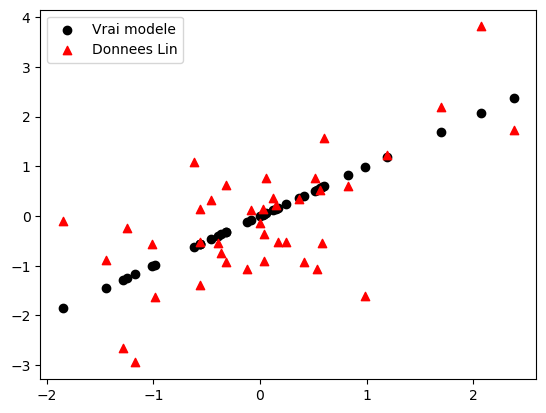

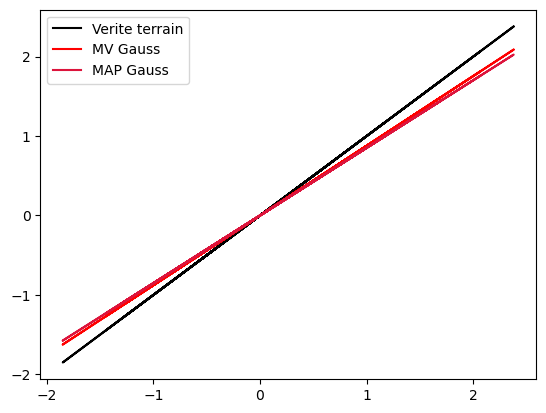

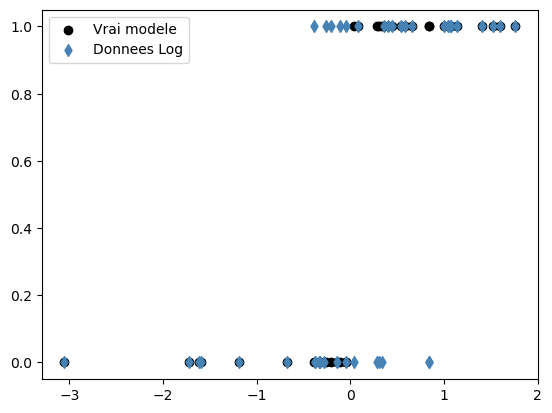

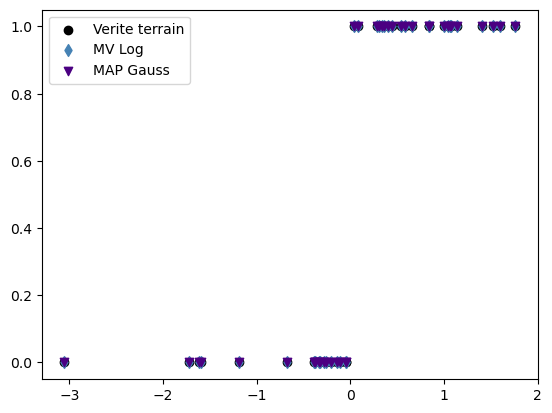

In [13]:
if d==1:
    # Affichage des donnees
    plt.figure()
    plt.scatter(Alin[:,0],blinstar,color='k',marker='o',label='Vrai modele')
    plt.scatter(Alin[:,0],blin,color='red',marker='^',label='Donnees Lin')
    plt.legend()
    plt.show()
    
    # Affichage des predictions
    plt.figure()
    plt.plot(Alin[:,0],blinstar,color='k',label='Verite terrain')
    plt.plot(Alin[:,0],Alin.dot(x_lin_none),color='red',label='MV Gauss')
    plt.plot(Alin[:,0],Alin.dot(x_lin_gauss),color='crimson',label='MAP Gauss')
    plt.legend()
    plt.show()
    
    # Affichage des donnees
    plt.figure()
    plt.scatter(Alog[:,0],blogstar,color='k',marker='o',label='Vrai modele')
    plt.scatter(Alog[:,0],blog,color='steelblue',marker='d',label='Donnees Log')
    plt.legend()
    plt.show()
    
    # Affichage des predictions
    plt.figure()
    plt.scatter(Alog[:,0],blogstar,marker='o',color='k',label='Verite terrain')
    plt.scatter(Alog[:,0],b_log_none,marker='d',color='steelblue',label='MV Log')
    plt.scatter(Alog[:,0],b_log_gauss,marker='v',color='indigo',label='MAP Gauss')
    plt.legend()
    plt.show()  

In [14]:
# Version 2.0 - C. W. Royer, octobre 2023.